# 1d Conv on EEG data

Step 1:
- build convolutional model

Step 2:
- run a training pipeline

In [1]:
import sys
sys.path.append('../')

In [2]:
from utils.dataset import EEGDataset
from pathlib import Path


eeg_dir = Path('/home/admin/work/NetworkMachineLearning_2023/EEGDataset/')
subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04']

data = EEGDataset(eeg_dir, subjects)

### Step 1 - Build model

In [3]:
import numpy as np
from sklearn import preprocessing
from utils.transforms import Compose
import torch
import torch.nn as nn 
from torch.utils.data import random_split, DataLoader
from utils.transforms import ToTensor, Flatten

In [4]:
class CNN(nn.Module):

    def __init__(self, n_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=n_channels, out_channels=5, kernel_size=3),
            nn.BatchNorm1d(num_features=5),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=5, out_channels=5, kernel_size=3),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.5),
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=5, out_channels=5, kernel_size=3),
            nn.LeakyReLU(),
            nn.AvgPool1d(kernel_size=2,stride=2),
            nn.Dropout(p=0.5),
        )

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=5, out_channels=5, kernel_size=3),
            nn.LeakyReLU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
        )

        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=5, out_channels=5, kernel_size=3),
            nn.LeakyReLU(),
            nn.AvgPool1d(kernel_size=35),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=5, out_features=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Initialization
        x = x.float()

        # Convolutions
        x = self.conv1(x) 
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.squeeze()

        # Fully connected layers
        x = self.fc1(x)

        return x
    

class LIN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lin = nn.Linear(input_size, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.lin(x)
        x = self.sig(x)
        return x 
    

class MLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(),
            nn.Dropout(),
        )
        self.hidden = nn.Sequential(
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Dropout(),
        )
        self.output = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)
        return x
    
    def init_weights(self):
        gain = nn.init.calculate_gain('leaky_relu')
        nn.init.xavier_normal_(self.input[0].weight, gain)
        nn.init.xavier_normal_(self.hidden[0].weight, gain)
        nn.init.xavier_normal_(self.output[0].weight)



Choose model and check number of parameters

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

# data preprocessing
transform = Compose([Flatten(), ToTensor()])
data.transform = transform
train, test = random_split(data, [0.8, 0.2])

train_loader = DataLoader(train, batch_size=200)
test_loader = DataLoader(test, batch_size=32)

# model
sample = data[0]['eeg']
input_size = sample.shape[0]

model = MLP(input_size).to(device)
model.init_weights()
print(sum([x.reshape(-1).shape[0] for x in model.parameters()]))

10256769


In [6]:
model.parameters

<bound method Module.parameters of MLP(
  (input): Sequential(
    (0): Linear(in_features=80000, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
  )
  (hidden): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Sigmoid()
  )
)>

### Train model

In [7]:
def train(dataloader, model, loss_fn, optimizer, device='cpu'):
    model.train()

    for batch in dataloader:
        X = batch['eeg'].to(device)
        y = batch['label'].to(device)

        # compute prediction error
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        #for name, param in model.named_parameters():
        #    print(name, param.grad)
            
        optimizer.step()

In [8]:
def valid(dataloader, model, loss_fn, device='cpu'):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()                    # set to eval to not compute gradient

    val_loss, correct = 0, 0
    with torch.no_grad():
        for batch in dataloader:
            X = batch['eeg'].to(device)
            y = batch['label'].float().to(device)

            pred = model(X).squeeze()
            val_loss += loss_fn(pred, y).item()
            correct += ((pred > 0.5) == y).type(torch.float).sum().item()
    val_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    return val_loss 

In [9]:
# loss
loss_fn = nn.BCELoss()

# optimizer
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)

epochs = 100
loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer, device=device)
    loss.append(valid(test_loader, model, loss_fn, device=device))

print('Done!')

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 50.4%, Avg loss: 0.696524 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 50.4%, Avg loss: 0.693094 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 50.4%, Avg loss: 0.700749 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 50.4%, Avg loss: 0.694930 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 50.4%, Avg loss: 0.693783 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 50.4%, Avg loss: 0.693286 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 50.4%, Avg loss: 0.693189 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 50.4%, Avg loss: 0.693660 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 50.4%, Avg loss: 0.703938 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 50.4%, Avg loss: 0.693730 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 49.6%, Avg los

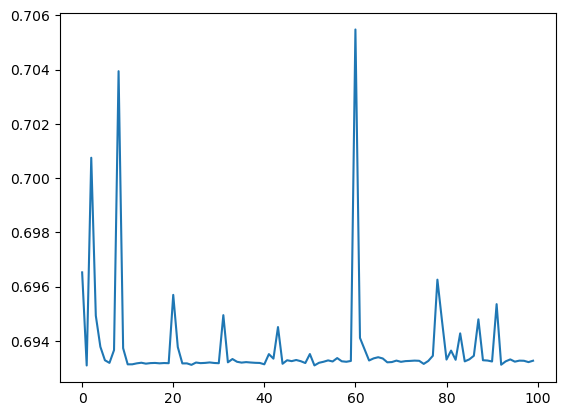

In [10]:
import matplotlib.pyplot as plt 

e = range(epochs)
plt.plot(e, loss)

#### Notes 

- Linear model: lr = 1 for 80 accuracy in 100 epochs, 1 subject

In [20]:
# training parameters
num_epochs = 150
batch_size = 32
base_lr = 0.00001
max_lr = 0.1

# Create model
model = MLP(input_size).to(device)

# Define loss and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=base_lr)

# Define a learning rate scheduler
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr)

# Training loop
losses = []
learning_rates = []
model.train()

for epoch in range(num_epochs):
    for batch in train_loader:
    
        X = batch['eeg'].to(device)
        y = batch['label'].to(device)

        # compute prediction error
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)
        losses.append(loss.item())
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        scheduler.step()

        print('current_lr: ', optimizer.param_groups[0]['lr'])
    

current_lr:  5.99950000000167e-05
current_lr:  0.00010998999999998899
current_lr:  0.00015998500000000569
current_lr:  0.00020997999999997798
current_lr:  0.0002599749999999947
current_lr:  0.0003099700000000114
current_lr:  0.0003599649999999837
current_lr:  0.00040996000000000045
current_lr:  0.00045995500000001714
current_lr:  0.0005099499999999894
current_lr:  0.0005599450000000061
current_lr:  0.0006099399999999784
current_lr:  0.0006599349999999951
current_lr:  0.0007099300000000118
current_lr:  0.0007599249999999841
current_lr:  0.0008099200000000009
current_lr:  0.0008599150000000175
current_lr:  0.0009099099999999898
current_lr:  0.0009599050000000066
current_lr:  0.0010098999999999787
current_lr:  0.0010598949999999956
current_lr:  0.0011098900000000122
current_lr:  0.0011598849999999844
current_lr:  0.0012098800000000013
current_lr:  0.001259875000000018
current_lr:  0.0013098699999999901
current_lr:  0.001359865000000007
current_lr:  0.0014098599999999792
current_lr:  0.001

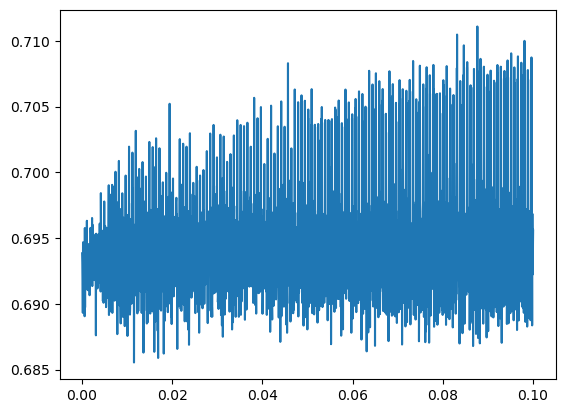

In [23]:
import matplotlib.pyplot as plt 

plt.plot(learning_rates, losses)

In [16]:
learning_rates

array([1.0000000e-05, 5.9995000e-05, 1.0999000e-04, ..., 5.0154985e-02,
       5.0104990e-02, 5.0054995e-02])